In [1]:
import numpy as np
import Mors as mors
import matplotlib.pyplot as plt
import os
import scipy.integrate as integrate
import pandas as pd

In [2]:
def massLossRate(efficiency, M_pl, R_pl, M_star):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth

    #need to get M_pl in actual mass
    Mp = M_pl * 5.97E24 #kg


    #same for R_pl
    Rp = R_pl * 6.37E6 #m

    #need flux over course of time for each case of rotator
    p10 = mors.Load('p10_stars/p10_m'+str(M_star)+'.pickle')
    p50 = mors.Load('p50_stars/p50_m'+str(M_star)+'.pickle')
    p90 = mors.Load('p90_stars/p90_m'+str(M_star)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)


    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    p10_Leuv = np.empty(len(t))
    p50_Leuv = np.empty(len(t))
    p90_Leuv = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p10_Leuv[i] = p10.Value(Age = age, Quantity='Leuv')
        
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p50_Leuv[i] = p50.Value(Age = age, Quantity='Leuv')
        
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')
        p90_Leuv[i] = p90.Value(Age = age, Quantity='Leuv')

    
    #F=L/4pir^2
    #need to find the orbital distance within the CHZ using findHZ
    r = np.mean(findHZ(M_star,t)) * 1.496E13
    
    p10_flux = (p10_Lx + p10_Leuv)/(4 * np.pi * r**2)
    p50_flux = (p50_Lx + p50_Leuv)/(4 * np.pi * r**2)
    p90_flux = (p90_Lx + p90_Leuv)/(4 * np.pi * r**2)
    
    #need radius of atmosphere
    R_atm = Rp*1.1 #meters

    #gravitational constant
    G = 6.67E-11 #si
    
    
    M_atm = 5E-3*Mp
    Mdot10 = np.pi*efficiency*p10_flux*R_atm**2*Rp/(G*Mp)   
    Mdot50 = np.pi*efficiency*p50_flux*R_atm**2*Rp/(G*Mp)  
    Mdot90 = np.pi*efficiency*p90_flux*R_atm**2*Rp/(G*Mp)
    
    '''
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    ax[0].plot(t,Mdot10)
    ax[0].plot(t,Mdot50)
    ax[0].plot(t,Mdot90)
    ax[0].set_title('Mass loss rate vs time')
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_ylabel('Mass loss rate (grams/s)')
    ax[0].set_xlabel('Age(10Myr-5Gyr)')
    '''
    
    #put Mdot in kg/year
    Mdot10_kg = Mdot10*1E-3*3.15E7
    Mdot50_kg = Mdot50*1E-3*3.15E7
    Mdot90_kg = Mdot90*1E-3*3.15E7
    '''
    #plot Mdot kg/year
    ax[2].plot(t,Mdot10_kg)
    ax[2].plot(t,Mdot50_kg)
    ax[2].plot(t,Mdot90_kg)
    ax[2].set_title('Mass loss rate vs time')
    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].set_ylabel('Mass loss rate (kg/yr)')
    ax[2].set_xlabel('Age(10Myr-5Gyr)')
    '''
    M10 = (M_atm - integrate.cumtrapz(y=Mdot10_kg, x=t*1e6)) / M_atm *100
    M50 = (M_atm - integrate.cumtrapz(y=Mdot50_kg, x=t*1e6)) / M_atm *100
    M90 = (M_atm - integrate.cumtrapz(y=Mdot90_kg, x=t*1e6)) / M_atm *100

    plt.plot(t[1:],M10,color='green')
    plt.plot(t[1:],M50)
    plt.plot(t[1:],M90)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1,1E2])
    plt.title('%mass remaining over time')
    plt.xlabel('Age (10Myr-5Gyr)')
    plt.ylabel('% mass')

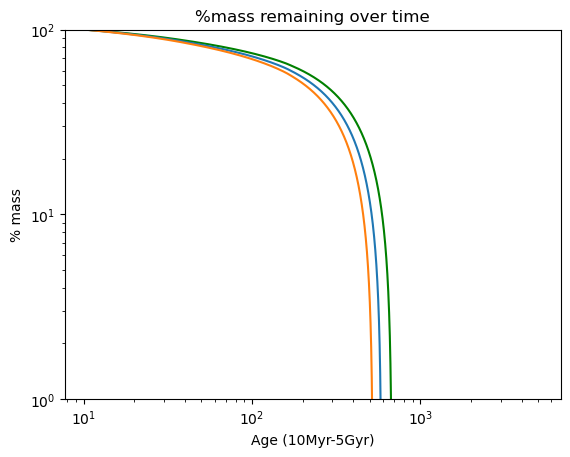

In [5]:
masses = [0.30204081632653057,0.5040816326530612,0.7061224489795918]
massLossRate(0.3, 0.5, 1, 0.30204081632653057)

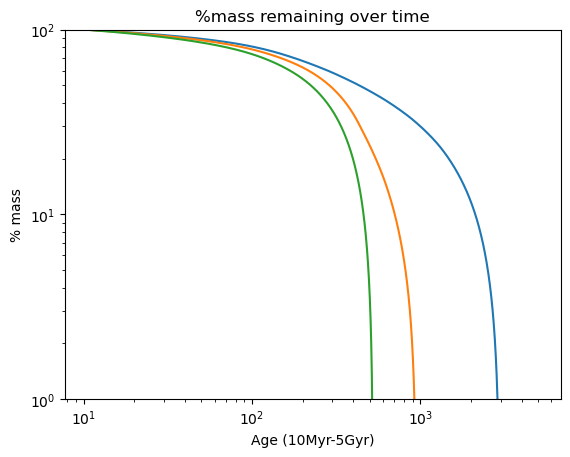

In [117]:
massLossRate(0.3, 0.5, 1, 0.5040816326530612)

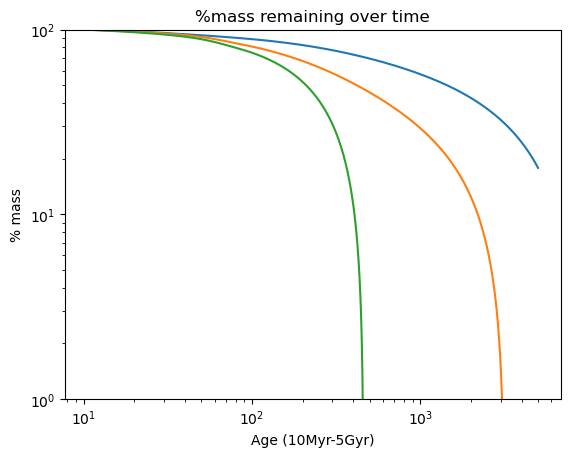

In [118]:
massLossRate(0.3, 0.5, 1, 0.7061224489795918)

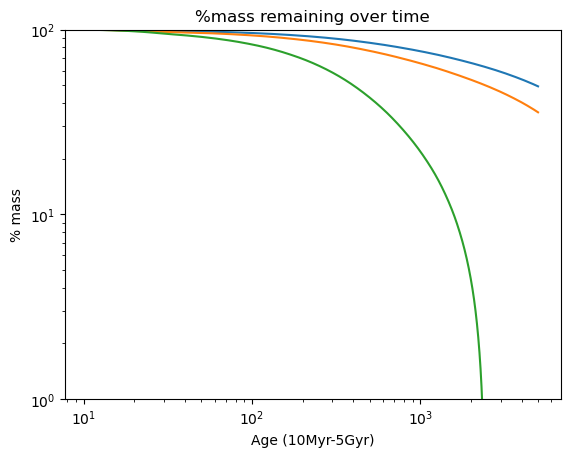

In [19]:
massLossRate(0.3,0.5,1,1.0204081632653061)

In [4]:
def findHZ(M_star,age):
    '''
    M_star in solar masses
    age in Myr
    '''
    
    HZbounds = np.empty((len(age),2))
    
    for i,t in enumerate(age):
        HZbounds[i]=(np.array([mors.aOrbHZ(Mstar=M_star,Age=t)['RecentVenus'],mors.aOrbHZ(Mstar=M_star, Age=t)['EarlyMars']]))

    #initial overlap is just the first HZ range
    overlap = HZbounds[0]
    
    for i,array in enumerate(HZbounds[1:]):
        if max(overlap[0], array[0]) <= min(overlap[1], array[1]):
            overlap = np.array((max(overlap[0], array[0]), min(overlap[1], array[1])))
    return overlap
    
                               
    

In [6]:
masses = np.linspace(0.1,1.2,50)
t = np.linspace(10,5000,100)

CHZ = np.empty((len(masses[9:])))

for i,mass in enumerate(masses[9:]):
    CHZ[i] = np.mean(findHZ(mass,t))
    



In [32]:
CHZ

array([0.22118183, 0.23445199, 0.24661667, 0.26064182, 0.27413284,
       0.2893758 , 0.30497032, 0.32130407, 0.33887101, 0.3562125 ,
       0.37649329, 0.39520384, 0.41829926, 0.43910443, 0.46402227,
       0.48863955, 0.51310376, 0.54095506, 0.56825521, 0.59817287,
       0.63003602, 0.66317524, 0.70199316, 0.7471388 , 0.7903469 ,
       0.8351682 , 0.87336992, 0.90995464, 0.95105568, 0.9910926 ,
       1.03846169, 1.08261871, 1.13578392, 1.1864815 , 1.24335282,
       1.30070315, 1.36770607, 1.44484543, 1.52183723, 1.61135873,
       1.69541563])

In [1]:
def ageAtLoss(efficiency, M_pl, R_pl, M_star, chz):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth

    #need to get M_pl in actual mass
    Mp = M_pl * 5.97E24 #kg


    #same for R_pl
    Rp = R_pl * 6.37E6 #m

    #need flux over course of time for each case of rotator
    p10 = mors.Load('p10_stars/p10_m'+str(M_star)+'.pickle')
    p50 = mors.Load('p50_stars/p50_m'+str(M_star)+'.pickle')
    p90 = mors.Load('p90_stars/p90_m'+str(M_star)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)


    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    p10_Leuv = np.empty(len(t))
    p50_Leuv = np.empty(len(t))
    p90_Leuv = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p10_Leuv[i] = p10.Value(Age = age, Quantity='Leuv')
        
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p50_Leuv[i] = p50.Value(Age = age, Quantity='Leuv')
        
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')
        p90_Leuv[i] = p90.Value(Age = age, Quantity='Leuv')

    
    #F=L/4pir^2
    #need to find the orbital distance within the CHZ using findHZ
    r = chz * 1.496E13
    
    p10_flux = (p10_Lx + p10_Leuv)/(4 * np.pi * r**2)
    p50_flux = (p50_Lx + p50_Leuv)/(4 * np.pi * r**2)
    p90_flux = (p90_Lx + p90_Leuv)/(4 * np.pi * r**2)
    
    #need radius of atmosphere
    R_atm = Rp*1.1 #meters

    #gravitational constant
    G = 6.67E-11 #si
    
    
    M_atm = 5E-3*Mp
    Mdot10 = np.pi*efficiency*p10_flux*R_atm**2*Rp/(G*Mp)   
    Mdot50 = np.pi*efficiency*p50_flux*R_atm**2*Rp/(G*Mp)  
    Mdot90 = np.pi*efficiency*p90_flux*R_atm**2*Rp/(G*Mp)
    
    
    #put Mdot in kg/year
    Mdot10_kg = Mdot10*1E-3*3.15E7
    Mdot50_kg = Mdot50*1E-3*3.15E7
    Mdot90_kg = Mdot90*1E-3*3.15E7
    
    M10 = (M_atm - integrate.cumtrapz(y=Mdot10_kg, x=t*1e6)) / M_atm *100
    M50 = (M_atm - integrate.cumtrapz(y=Mdot50_kg, x=t*1e6)) / M_atm *100
    M90 = (M_atm - integrate.cumtrapz(y=Mdot90_kg, x=t*1e6)) / M_atm *100

    #print(min(M10),min(M50),min(M90))
    if len(t[np.where(M10<=1)]) != 0:
        return t[np.where(M10 <= 1)][0], t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M50 <= 1)]) != 0:
        return 0,t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M90 <= 1)]) != 0:
        return 0,0, t[np.where(M90 <= 1)][0]
    else:
        return 0,0,0

In [8]:
ageAtLoss(0.3,0.5,1,all_data['Mass'][32],all_data)

NameError: name 'all_data' is not defined

In [9]:
test_frame = pd.DataFrame(columns=['a','a'])
test_frame.to_csv('test.csv')

In [ ]:
columns = ['Mass','CHZ','age when mass depleted(10th)','age when mass depleted(50th)','age when mass depleted(90th)']
all_data = pd.DataFrame(columns=columns)
all_data['Mass'] = np.linspace(0.1,1.2,50)[9:]
all_data['CHZ'] = CHZ
for i,mass in enumerate(all_data['Mass']):
    ages = ageAtLoss(0.3,0.5,1,mass,all_data['CHZ'][i])
    all_data['age when mass depleted(10th)'][i] = ages[0]
    all_data['age when mass depleted(50th)'][i] = ages[1]
    all_data['age when mass depleted(90th)'][i] = ages[2]
    
all_data.to_csv('CHZ_data.csv')


In [11]:
loaded_data = pd.read_csv('CHZ_data.csv')

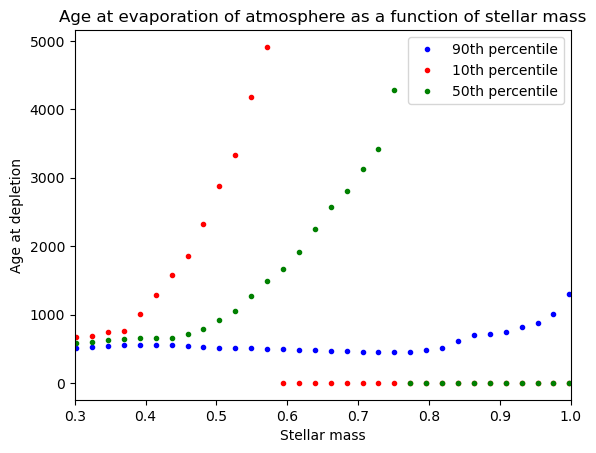

In [30]:
plt.plot(loaded_data['Mass'],loaded_data['age when mass depleted(90th)'],'.',color='blue',label='90th percentile')
plt.ylabel('Age at depletion')
plt.xlabel('Stellar mass')
plt.xlim([0.3,1])
plt.title('Age at evaporation of atmosphere as a function of stellar mass')
#plt.ylim([5,5000])
plt.plot(loaded_data['Mass'],loaded_data['age when mass depleted(10th)'],'.',color='red', label='10th percentile')
plt.plot(loaded_data['Mass'],loaded_data['age when mass depleted(50th)'],'.',color='green',label='50th percentile')
plt.legend()

In [90]:
masses = np.linspace(0.12,0.13,10)
for mass in masses:
    if type(findHZ(mass,np.linspace(10,5000,1000))) is np.ndarray:
        print(mass)
        
           

0.1288888888888889
0.13


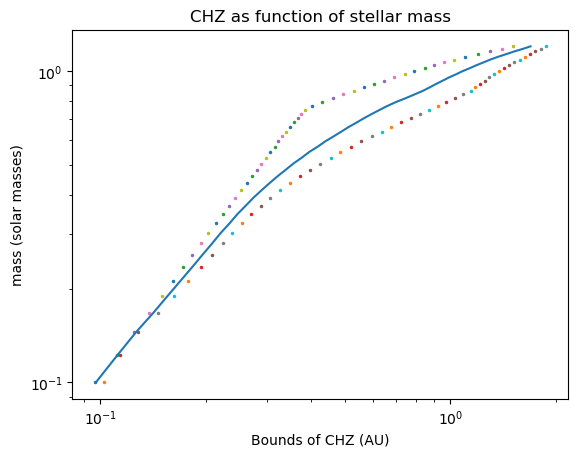

In [28]:
#plot the CHZ as function of stellar mass
masses = np.linspace(0.1,1.2,50)
ages = np.linspace(10,5000,50)
for mass in masses:
    bounds = findHZ(mass, ages)
    plt.plot(bounds[0],mass,'.',markersize=3)
    plt.plot(bounds[1],mass,'.',markersize=3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('mass (solar masses)')
plt.xlabel('Bounds of CHZ (AU)')
plt.title('CHZ as function of stellar mass')
plt.plot(CHZ,masses)

In [40]:
def plotRemains(efficiency, M_pl, R_pl, M_star,chz):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth

    #need to get M_pl in actual mass
    Mp = M_pl * 5.97E24 #kg


    #same for R_pl
    Rp = R_pl * 6.37E6 #m

    #need flux over course of time for each case of rotator
    p10 = mors.Load('p10_stars/p10_m'+str(M_star)+'.pickle')
    p50 = mors.Load('p50_stars/p50_m'+str(M_star)+'.pickle')
    p90 = mors.Load('p90_stars/p90_m'+str(M_star)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)


    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    p10_Leuv = np.empty(len(t))
    p50_Leuv = np.empty(len(t))
    p90_Leuv = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p10_Leuv[i] = p10.Value(Age = age, Quantity='Leuv')
        
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p50_Leuv[i] = p50.Value(Age = age, Quantity='Leuv')
        
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')
        p90_Leuv[i] = p90.Value(Age = age, Quantity='Leuv')

    
    #F=L/4pir^2
    #need to find the orbital distance within the CHZ using findHZ
    r = chz * 1.496E13
    
    p10_flux = (p10_Lx + p10_Leuv)/(4 * np.pi * r**2)
    p50_flux = (p50_Lx + p50_Leuv)/(4 * np.pi * r**2)
    p90_flux = (p90_Lx + p90_Leuv)/(4 * np.pi * r**2)
    
    #need radius of atmosphere
    R_atm = Rp*1.1 #meters

    #gravitational constant
    G = 6.67E-11 #si
    
    
    M_atm = 5E-3*Mp
    Mdot10 = np.pi*efficiency*p10_flux*R_atm**2*Rp/(G*Mp)   
    Mdot50 = np.pi*efficiency*p50_flux*R_atm**2*Rp/(G*Mp)  
    Mdot90 = np.pi*efficiency*p90_flux*R_atm**2*Rp/(G*Mp)
    
    
    #put Mdot in kg/year
    Mdot10_kg = Mdot10*1E-3*3.15E7
    Mdot50_kg = Mdot50*1E-3*3.15E7
    Mdot90_kg = Mdot90*1E-3*3.15E7
    
    M10 = (M_atm - integrate.cumtrapz(y=Mdot10_kg, x=t*1e6)) / M_atm *100
    M50 = (M_atm - integrate.cumtrapz(y=Mdot50_kg, x=t*1e6)) / M_atm *100
    M90 = (M_atm - integrate.cumtrapz(y=Mdot90_kg, x=t*1e6)) / M_atm *100

    return M10,M50,M90
   

In [39]:
loaded_data

,Unnamed: 0,Mass,CHZ,age when mass depleted(10th),age when mass depleted(50th),age when mass depleted(90th)
0,0,0.302041,0.221182,668.745875,579.914991,516.535654
1,1,0.324490,0.234452,693.199320,601.374137,531.008101
2,2,0.346939,0.246617,740.110011,630.818082,546.478648
3,3,0.369388,0.260642,764.563456,638.802880,550.471047
4,4,0.391837,0.274133,1005.604560,650.780078,550.970097
5,5,0.414286,0.289376,1291.560156,657.766777,554.463446
6,6,0.436735,0.304970,1578.014801,662.757276,548.474847
7,7,0.459184,0.321304,1861.475148,714.159416,539.990999
8,8,0.481633,0.338871,2319.602960,793.508351,523.023302
9,9,0.504082,0.356212,2875.544554,922.762276,517.533753


/tmp/ipykernel_21157/1202508829.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[0].set_ylim([0,100]),ax[1].set_ylim([0,100]),ax[2].set_ylim([0,100])


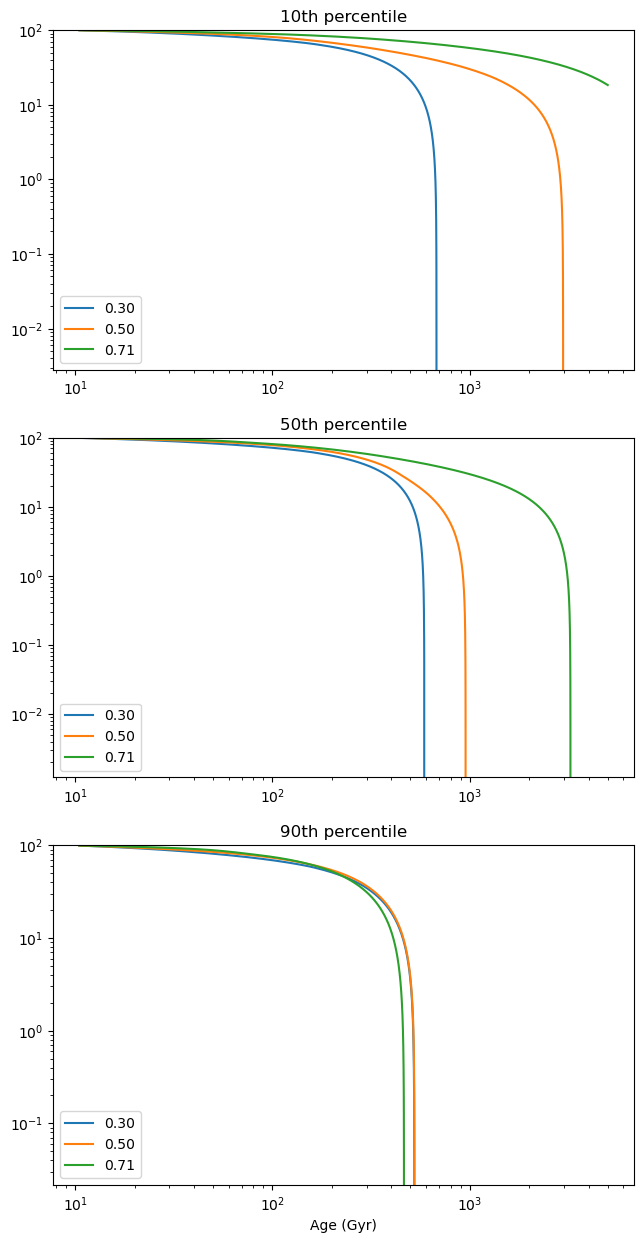

In [64]:
masses = [0.30204081632653057,0.5040816326530612,0.7061224489795918]
fig,ax=plt.subplots(3,1,figsize=(7.5,15))
CHZ = [loaded_data['CHZ'][0],loaded_data['CHZ'][9],loaded_data['CHZ'][18]]
t = np.linspace(10,5000,10000)

for i,mass in enumerate(masses):
    ax[0].plot(t[1:],plotRemains(0.3,0.5,1,mass,CHZ[i])[0],label=f"{mass:.2f}")
    ax[1].plot(t[1:],plotRemains(0.3,0.5,1,mass,CHZ[i])[1],label=f"{mass:.2f}")
    ax[2].plot(t[1:],plotRemains(0.3,0.5,1,mass,CHZ[i])[2],label=f"{mass:.2f}")
ax[0].set_yscale('log'),ax[1].set_yscale('log'),ax[2].set_yscale('log')
ax[0].set_xscale('log'),ax[1].set_xscale('log'),ax[2].set_xscale('log')
ax[0].set_ylim([0,100]),ax[1].set_ylim([0,100]),ax[2].set_ylim([0,100])
ax[0].set_title('10th percentile')
ax[1].set_title('50th percentile')
ax[2].set_title('90th percentile')

ax[2].set_xlabel('Age (Gyr)')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='lower left')